# Transient Heat Conduction in Various Geometries

Keywords: ipopt usage, dae, differential-algebraic equations, pde, partial differential equations

## Imports

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D 
  
import shutil
import sys
import os.path

if not shutil.which("pyomo"):
    !pip install -q pyomo
    assert(shutil.which("pyomo"))

if not (shutil.which("ipopt") or os.path.isfile("ipopt")):
    if "google.colab" in sys.modules:
        !wget -N -q "https://ampl.com/dl/open/ipopt/ipopt-linux64.zip"
        !unzip -o -q ipopt-linux64
    else:
        try:
            !conda install -c conda-forge ipopt 
        except:
            pass

assert(shutil.which("ipopt") or os.path.isfile("ipopt"))
from pyomo.environ import *
from pyomo.dae import *

## Rescaling the heat equation

Transport of heat in a solid is described by the familiar thermal diffusion model

$$
\begin{align*}
\rho C_p\frac{\partial T}{\partial t} & = \nabla\cdot(k\nabla T)
\end{align*}
$$

We'll assume the thermal conductivity $k$ is a constant, and define thermal diffusivity in the conventional way

$$
\begin{align*}
\alpha & = \frac{k}{\rho C_p}
\end{align*}
$$

We will further assume symmetry with respect to all spatial coordinates except $r$ where $r$ extends from $-R$ to $+R$. The boundary conditions are

$$
\begin{align*}
T(t,R) & = T_{\infty} & \forall t > 0 \\
\nabla T(t,0) & = 0 & \forall t \geq 0 
\end{align*}
$$

where we have assumed symmetry with respect to $r$ and uniform initial conditions $T(0, r) = T_0$ for all $0 \leq r \leq R$. Following standard scaling procedures, we introduce the dimensionless variables

$$
\begin{align*}
T' & = \frac{T - T_0}{T_\infty - T_0} \\
r' & = \frac{r}{R} \\
t' & = t \frac{\alpha}{R^2}
\end{align*}
$$

## Dimensionless model

Under these conditions the problem reduces to 

$$
\begin{align*}
\frac{\partial T'}{\partial t'} & = \nabla^2 T'
\end{align*}
$$

with auxiliary conditions

$$
\begin{align*}
T'(0, r') & = 0 & \forall 0 \leq r' \leq 1\\
T'(t', 1) & = 1 & \forall t' > 0\\
\nabla T'(t', 0) & = 0 & \forall t' \geq 0 \\
\end{align*}
$$

which we can specialize to specific geometries.

## Preliminary code

In [7]:
def model_plot(m):
    r = sorted(m.r)
    t = sorted(m.t)

    rgrid = np.zeros((len(t), len(r)))
    tgrid = np.zeros((len(t), len(r)))
    Tgrid = np.zeros((len(t), len(r)))

    for i in range(0, len(t)):
        for j in range(0, len(r)):
            rgrid[i,j] = r[j]
            tgrid[i,j] = t[i]
            Tgrid[i,j] = m.T[t[i], r[j]].value

    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    ax.set_xlabel('Distance r')
    ax.set_ylabel('Time t')
    ax.set_zlabel('Temperature T')
    p = ax.plot_wireframe(rgrid, tgrid, Tgrid)
    plt.show()

## Planar coordinates

Suppressing the prime notation, for a slab geometry the model specializes to 

$$
\begin{align*}
\frac{\partial T}{\partial t} & = \frac{\partial^2 T}{\partial r^2}
\end{align*}
$$

with auxiliary conditions

$$
\begin{align*}
T(0, r) & = 0 & \forall 0 \leq r \leq 1 \\
T(t, 1) & = 1 & \forall t > 0\\
\frac{\partial T}{\partial r} (t, 0) & = 0 & \forall t \geq 0 \\
\end{align*}
$$

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

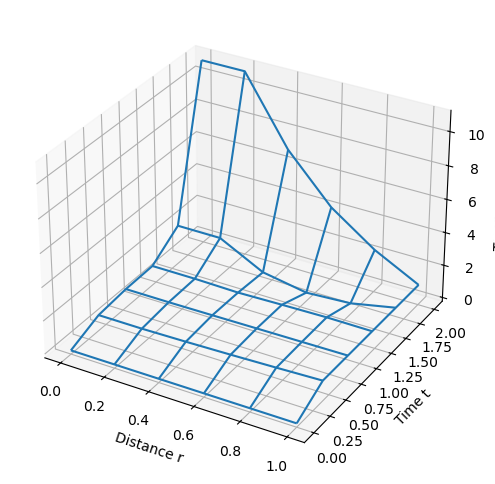

In [32]:
m = ConcreteModel()

m.r = ContinuousSet(bounds=(0,1))
m.t = ContinuousSet(bounds=(0,2))

m.T = Var(m.t, m.r)

m.dTdt   = DerivativeVar(m.T, wrt=m.t)
m.dTdr   = DerivativeVar(m.T, wrt=m.r)
m.d2Tdr2 = DerivativeVar(m.T, wrt=(m.r, m.r), bounds=(-100,100))

@m.Constraint(m.t, m.r)
def pde(m, t, r):
    if t == 0:
        return Constraint.Skip
    if r == 0 or r == 1:
        return Constraint.Skip
    return m.dTdt[t,r] == m.d2Tdr2[t,r]

#m.obj = Objective(expr=1)
@m.Objective()
def obj(m):
    return sum(m.d2Tdr2[t,r] for t in m.t for r in m.r)

# Initial condition
m.ic  = Constraint(m.r, rule=lambda m, r:    m.T[0,r] == 0 if r > 0 and r < 1 else Constraint.Skip)

# Boundary conditions on temperature
m.bc1 = Constraint(m.t, rule=lambda m, t:    m.T[t,1] == 1)

# Boundary conditions on temperature gradient
m.bc2 = Constraint(m.t, rule=lambda m, t: m.dTdr[t,0] == 0)

TransformationFactory('dae.finite_difference').apply_to(m, nfe=5, scheme='FORWARD', wrt=m.r)
TransformationFactory('dae.finite_difference').apply_to(m, nfe=5, scheme='FORWARD', wrt=m.t)

# Consequence of initial condition
for r in m.r:
    m.dTdr[0,r].fix(0)

# Consequence of boundary condition
for t in m.t:
    m.dTdt[t,1].fix(0)

SolverFactory('ipopt').solve(m, tee=True).write()
model_plot(m)

In [29]:
m.pprint()

4 Var Declarations
    T : Size=36, Index=t*r
        Key        : Lower : Value                  : Upper : Fixed : Stale : Domain
            (0, 0) :  None : 1.9934191008527442e-11 :  None : False : False :  Reals
          (0, 0.2) :  None : 1.9934190878274565e-11 :  None : False : False :  Reals
          (0, 0.4) :  None : 2.0131534553692074e-11 :  None : False : False :  Reals
          (0, 0.6) :  None :   2.05675743578617e-11 :  None : False : False :  Reals
          (0, 0.8) :  None : 2.1360395367155714e-11 :  None : False : False :  Reals
            (0, 1) :  None : 2.2866649101947802e-11 :  None : False : False :  Reals
          (0.4, 0) :  None :     0.7096710300078027 :  None : False : False :  Reals
        (0.4, 0.2) :  None :     0.7096710300078027 :  None : False : False :  Reals
        (0.4, 0.4) :  None :     0.7566016438705299 :  None : False : False :  Reals
        (0.4, 0.6) :  None :     0.8225278583043435 :  None : False : False :  Reals
        (0.4, 0.8) 

## Cylindrical coordinates

Suppressing the prime notation, for a cylindrical geometry the model specializes to 

$$
\begin{align*}
\frac{\partial T}{\partial t} & = \frac{1}{r}\frac{\partial}{\partial r}\left(r\frac{\partial T}{\partial r}\right)
\end{align*}
$$

Expanding,

$$
\begin{align*}
\frac{\partial T}{\partial t} & = \frac{\partial^2 T}{\partial t^2} + \frac{1}{r}\frac{\partial T}{\partial r}
\end{align*}
$$

with auxiliary conditions

$$
\begin{align*}
T(0, r) & = 0 & \forall 0 \leq r \leq 1\\
T(t, 1) & = 1 & \forall t > 0\\
\frac{\partial T}{\partial r} (t, 0) & = 0 & \forall t \geq 0 \\
\end{align*}
$$

In [4]:
m = ConcreteModel()

m.r = ContinuousSet(bounds=(0,1))
m.t = ContinuousSet(bounds=(0,2))

m.T = Var(m.t, m.r)

m.dTdt   = DerivativeVar(m.T, wrt=m.t)
m.dTdr   = DerivativeVar(m.T, wrt=m.r)
m.d2Tdr2 = DerivativeVar(m.T, wrt=(m.r, m.r))

m.pde = Constraint(m.t, m.r, rule=lambda m, t, r: m.dTdt[t,r] == m.d2Tdr2[t,r] + (1/r)*m.dTdr[t,r]
        if r > 0 and r < 1 and t > 0 else Constraint.Skip)

m.ic  = Constraint(m.r, rule=lambda m, r:    m.T[0,r] == 0)
m.bc1 = Constraint(m.t, rule=lambda m, t:    m.T[t,1] == 1 if t > 0 else Constraint.Skip)
m.bc2 = Constraint(m.t, rule=lambda m, t: m.dTdr[t,0] == 0)

TransformationFactory('dae.finite_difference').apply_to(m, nfe=20, wrt=m.r, scheme='CENTRAL')
TransformationFactory('dae.finite_difference').apply_to(m, nfe=50, wrt=m.t, scheme='BACKWARD')
SolverFactory('ipopt').solve(m,tee=True).write()

model_plot(m)

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

## Spherical coordinates

Suppressing the prime notation, for a cylindrical geometry the model specializes to 

$$
\begin{align*}
\frac{\partial T}{\partial t} & = \frac{1}{r^2}\frac{\partial}{\partial r}\left(r^2\frac{\partial T}{\partial r}\right)
\end{align*}
$$

Expanding,

$$
\begin{align*}
\frac{\partial T}{\partial t} & = \frac{\partial^2 T}{\partial t^2} + \frac{2}{r}\frac{\partial T}{\partial r}
\end{align*}
$$

with auxiliary conditions

$$
\begin{align*}
T(0, r) & = 0 & \forall 0 \leq r \leq 1\\
T(t, 1) & = 1 & \forall t > 0\\
\frac{\partial T}{\partial r} (t, 0) & = 0 & \forall t \geq 0 \\
\end{align*}
$$

In [5]:
m = ConcreteModel()

m.r = ContinuousSet(bounds=(0,1))
m.t = ContinuousSet(bounds=(0,2))

m.T = Var(m.t, m.r)

m.dTdt   = DerivativeVar(m.T, wrt=m.t)
m.dTdr   = DerivativeVar(m.T, wrt=m.r)
m.d2Tdr2 = DerivativeVar(m.T, wrt=(m.r, m.r))

m.pde = Constraint(m.t, m.r, rule=lambda m, t, r: m.dTdt[t,r] == m.d2Tdr2[t,r] + (2/r)*m.dTdr[t,r]
        if r > 0 and r < 1 and t > 0 else Constraint.Skip)

m.ic  = Constraint(m.r, rule=lambda m, r:    m.T[0,r] == 0)
m.bc1 = Constraint(m.t, rule=lambda m, t:    m.T[t,1] == 1 if t > 0 else Constraint.Skip)
m.bc2 = Constraint(m.t, rule=lambda m, t: m.dTdr[t,0] == 0)

TransformationFactory('dae.finite_difference').apply_to(m, nfe=20, wrt=m.r, scheme='CENTRAL')
TransformationFactory('dae.finite_difference').apply_to(m, nfe=50, wrt=m.t, scheme='BACKWARD')
SolverFactory('ipopt', tee=True).solve(m, tee=True).write()

model_plot(m)

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://